# Quaternion Complementary Filter

Kevin Walchko

---

This complementary filter estimates the attitude of an object from its accelerometer and gyroscope. There are pro's and con's to using each sensor.

- Accelerometer
    - Only works for **directly** measuring Euler angles roll and pitch (see Appendix A for derivation)
    - Typically need to pass signal through a low pass filter (LPF) to weed out high frequency noise from motors or other sources
    - Acceleration from movement will degrade performce since the filter will interprete the motion as tilt
    - LFP filters out short duration movement and leaves long duration gravity reading in tact
        - LFP causes a delay between measurement and system seeing measurement in the filter's output (i.e., lag)
- Gyroscope
    - Doesn't measure an angle, but the angular change, need to integrate sensor readings to recover the current angle. Thus this sensor is **indirectly** able to measure its orientation through math
        - $angle_{t} = angle_{t-1} + scale * (gyro_{t} + bias + noise) * \Delta t$
        - Sensors are not idea and have scaling errors and biases that *can be* calibrated for
        - Unfortunately there is measurement noise that cannot be calibrated out, but can be measured to use in a Kalman Filter or other statistical filter. Additionally, this can also help to set cutoff for a HPF
        - Sensor noise also gets integrated into the attitude estimate and this is the cause of **drift**
    - Can be used to estimate the roll, pitch, and Yaw
    - Gyro give fast results
    - Typically pass through a high pass filter (HPF) to help with measurement noise. Even when the sensor is perfectly still, there will still be small changing measurements that can get integrated and produce **drift**

Additionally, you can use a magnetometer to measure the Earth's magnetic field and understand your orientation (Yaw angle or Heading) relative to magnetic North.

- Magnetometer
    - Used to directly measure the yaw angle relative to magnetic North
        - Note, there is a differnce between Earth's magnetic North and a map's North. You need to account for the ???
    - Sensitive to magnetic field disturbances from motors, RF energy, and other disturbances (Soft-Iron and Hard-Iron distortion) ... this can (to some extend) be corrected via calibration *if* all disturbances can be accounted for (which can be hard)
    - Mainly measuring the horizontal and vertical component of the Earth's magnetic field
    - Generally the vertical is the larger part with it either positive (coming out of the Earth) in the Souther hemisphere or negative in the Northern hemisphere ... see diagram below

![](geomagnetic-field.jpg)

## Overall

These filters can:

- Help address noise, drift and short accelerations
- Faster than Kalman filters
- Far less computational than Kalman filters which makes them good for micro controllers
- Fast responding (less lag) than other filters
- Less theory to understand than Kalman filters and easier to implement (even in assembly code if you had too ... but who does that now?)

These filters can be used for other sensor combinations too.

$$
H_{altitude} = H_{Lidar} + L (H_{Barometer} - H_{Lidar})
$$

where $L$ is a fixed gain that scales the differences.

## References

- [The Balance Filter](filter.pdf)
- [AHRS Library](https://ahrs.readthedocs.io/en/latest/filters/complementary.html)
- [NVSL Quadcopter class](https://github.com/NVSL/QuadClass-Resources)
- [NVSL microWii code](https://github.com/NVSL/Quadcopter-Class-Lab-06)
- [AHRS: World Magnetic Model Explaination](https://ahrs.readthedocs.io/en/latest/wmm.html)
- MDPI Sensors: [Complete Tri-Axis Magnetometer Calibration with a Gyro Auxiliary](https://github.com/walchko/bearsnacks/blob/main/navigation-and-mapping/sensor-calibration/calibration-magnetometer/sensors-17-01223-v2.pdf)

## Gyro Update

This is the normal discrete integration of a quaternion from 
gyroscope readings.

$$
q_\omega = q_{t-1} + \frac {1}{2} q_{t-1} \otimes \omega \Delta t
$$

## Accelerometer Update

Since the accelerometer knows the direction to the center of the Earth,
it can calculate the roll and pitch. This is because, as you move the
accelerometer, the gravitational force is sensed on the x and y axis.
However, there is no force sensed on the z axis since it is parallel
to the gravity vector.

$$
\begin{array}{rcl}
a &=& \frac {a} {\| a \|} \\
roll = \phi &=& \mathrm{arctan2}(a_y, a_z) \\
pitch = \theta &=& \mathrm{arctan2}(-a_x, \sqrt{a_y^2 + a_z^2}) \\
yaw = \psi &=& 0.0
\end{array}
$$

Then you can build a quaternion from the Euler angles calculated from the
accelerometer.

$$
q_{am} = \begin{bmatrix} q_w & q_x & q_y & q_z \end{bmatrix}
$$

## Magnetometer Update

If a magnetometer is available, the yaw angle can be recovered
from the Earth's magnetic field.

$$
\begin{array}{rcl}
b &=& \frac {b} {\| b \|} \\
\mathbf{b} &=&
\begin{bmatrix}
    \cos\theta & \sin\theta\sin\phi & \sin\theta\cos\phi \\
    0 & \cos\phi & -\sin\phi \\
    -\sin\theta & \cos\theta\sin\phi & \cos\theta\cos\phi
\end{bmatrix}
\begin{bmatrix}m_x \\ m_y \\ m_z\end{bmatrix} \\
\begin{bmatrix}b_x \\ b_y \\ b_z\end{bmatrix} &=&
\begin{bmatrix}
    m_x\cos\theta + m_y\sin\theta\sin\phi + m_z\sin\theta\cos\phi \\
    m_y\cos\phi - m_z\sin\phi \\
    -m_x\sin\theta + m_y\cos\theta\sin\phi + m_z\cos\theta\cos\phi
\end{bmatrix}
\end{array}
$$

$$
\begin{array}{rcl}
    \psi &=& \mathrm{arctan2}(-b_y, b_x) \\
    &=& \mathrm{arctan2}\big(m_z\sin\phi - m_y\cos\phi, \; m_x\cos\theta + \sin\theta(m_y\sin\phi + m_z\cos\phi)\big)
    \end{array}
$$

## Filter Update

$$
q = (1 - \alpha) q_\omega + \alpha q_{am}
$$

where the filter gain $\alpha \in [0,1]$. Also $\alpha$ has the following relation to the filter's desired
time constant $\tau$.

**wait, these don't look right**

$$
\tau = \frac {\alpha \Delta t} {1 - \alpha} \\
\alpha = \frac {\tau}{\tau + \Delta t}
$$

### Example

- $\alpha$ is 0.02
- Sampling rate is 100 Hz or $\Delta t$ is 0.01

$$
\tau = \frac {0.98 \cdot 0.01} {0.02} = 0.49
$$



In [39]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from squaternion import Quaternion
import yivo

In [5]:
def plot(ts,q,title):
    plt.figure(figsize=(15,5))
    qq = np.array(q)
    plt.subplot(121)
    plt.plot(ts,qq)
    plt.title(title)
    plt.grid(True);

    plt.subplot(122)
    rpy = np.array([Quaternion(*x).to_euler(degrees=True) for x in qq])
    plt.plot(ts,rpy[:,0],label="roll")
    plt.plot(ts,rpy[:,1],label="pitch")
    plt.plot(ts,rpy[:,2],label="yaw")
    plt.grid(True)
    plt.legend();

In [50]:
def getAGMQPTData():
    fname = "agmqpt.pkl"
    with open(fname, "rb") as fd:
        data = pickle.load(fd)
    d = []
    for m in data:
        if type(m) == yivo.packet.ImuAGMQPT:
            d.append(m)
    d = np.array(d)

    accel = d[:,0:3]
    gyro = d[:,3:6]
    imutemp = d[:,6]
    mag = d[:,7:10]
    q = d[:,10:14]
    press = d[:,14]
    temp = d[:,15]
    ts = d[:,16] * 0.001
    ts = ts - min(ts)
    return accel, gyro, imutemp, mag, q, press, temp, ts 

In [51]:
def getAGTData():
    fname = "agt.pkl"
    with open(fname, "rb") as fd:
        data = pickle.load(fd)
        
        accel = np.array(data["accel"])
        gyro = np.array(data["gyro"])
        temp = np.array(data["temp"])
        ts = np.array(data["ts"])*0.001
        ts = ts - min(ts)
    return accel, gyro, temp, ts 

In [254]:
# accel, gyro, imutemp, mag, q, press, temp, ts  = getAGMQPTData()
accel, gyro, temp, ts = getAGTData()

print(f"{len(accel)} data points found")

gyro = gyro*np.pi/180

# bias correction
samp = 600
acc_corr =  np.mean(accel[:samp,:],0) - np.array([0,0,1])
gyro_corr = np.mean(gyro[:samp,:],0)
print(f"Accel correction: {acc_corr} g")  
print(f"Gyro correction: {gyro_corr} rad/sec")

accel = accel - acc_corr
gyro = gyro - gyro_corr

mfs = np.mean(1/np.diff(ts))
minfs = np.min(1/np.diff(ts))
maxfs = np.max(1/np.diff(ts))
print(f"Sample Freq {mfs:.1f} Hz (max/min: {maxfs:.1f} / {minfs:.1f} Hz)")

3844 data points found
Accel correction: [-0.05808025 -0.008273    0.01401567] g
Gyro correction: [0.00853987 0.00198139 0.00448299] rad/sec
Sample Freq 126.7 Hz (max/min: 142.9 / 111.1 Hz)


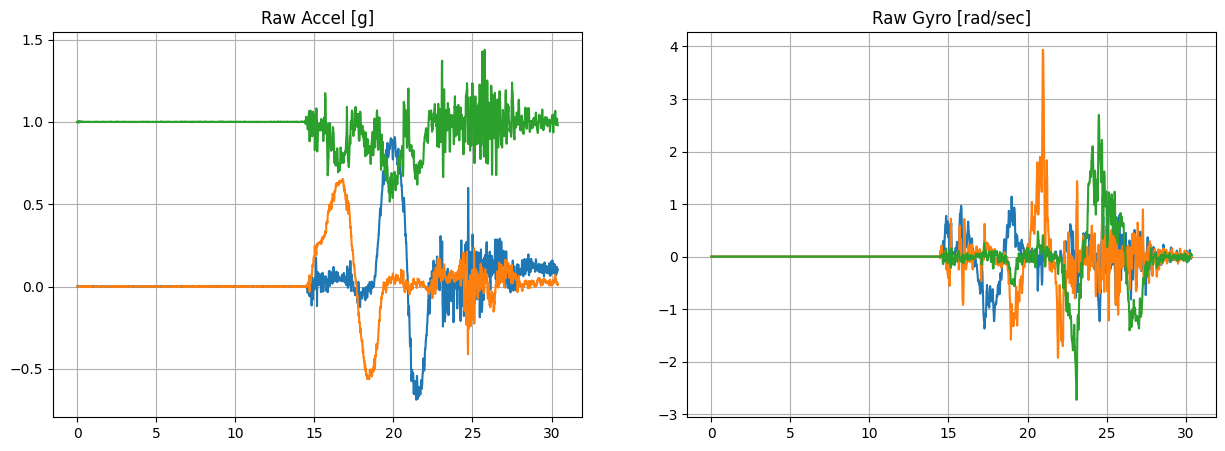

In [255]:
plt.figure(figsize=(15,5))
plt.subplot(121);plt.plot(ts,accel);plt.grid(True);plt.title("Raw Accel [g]")
plt.subplot(122);plt.plot(ts,gyro);plt.grid(True);plt.title("Raw Gyro [rad/sec]");

In [256]:
class CF:
    """
    Performance increases if the bias is removed and any scaling performed
    on the sensor readings before using the filter.
    
    For accelerometers, there is no need to remove gravity since the 
    values will be normalized.
    
    https://ahrs.readthedocs.io/en/latest/filters/complementary.html
    """
    def __init__(self,aa=0.02):
        self.q = Quaternion()
        self.aa = aa
        
    def update(self, a, g, dt, m=None):
        """
        Update attitude quaternion with accelerometer and gyroscope 
        readings. Optionally, a magnitometer can be used to better
        recover the yaw orientation.
        
        a: accel [g's]
        g: gyro [rad/sec]
        m: mag [uT]
        dt: time step [sec]
        """
        dt = float(dt)
        qw = self.q + 0.5*dt*self.q*Quaternion(0,g[0], g[1], g[2])
        
        a = a / np.linalg.norm(a)
        
        # https://academicworks.cuny.edu/cgi/
        #    viewcontent.cgi?referer=&httpsredir=1&article=1247&context=cc_pubs
        # Fig 2, pg 19315
        # rot = self.q.to_rot() # value?
        # a = rot @ a           # value?
        
        ax,ay,az = a
        roll = np.arctan2(ay,az)
        pitch = np.arctan2(-ax, np.sqrt(ay**2 + az**2))
        
        if m is None:
            yaw = 0.0
        else:
            mx,my,mz = m / np.linalg.norm(m)
            x = mx*np.cos(pitch)+mz*np.sin(pitch)
            y = mx*np.sin(roll)*np.sin(pitch)+my*np.cos(roll)-mz*np.sin(roll)*np.cos(pitch)
            yaw = np.pi/2 - np.arctan2(y, x) # or np.atan2(x,y) is the same thing
            
        qam = Quaternion.from_euler(roll, pitch, yaw)
        
        self.q = (1-self.aa) * qw + self.aa * qam
        return self.q

## Gyro

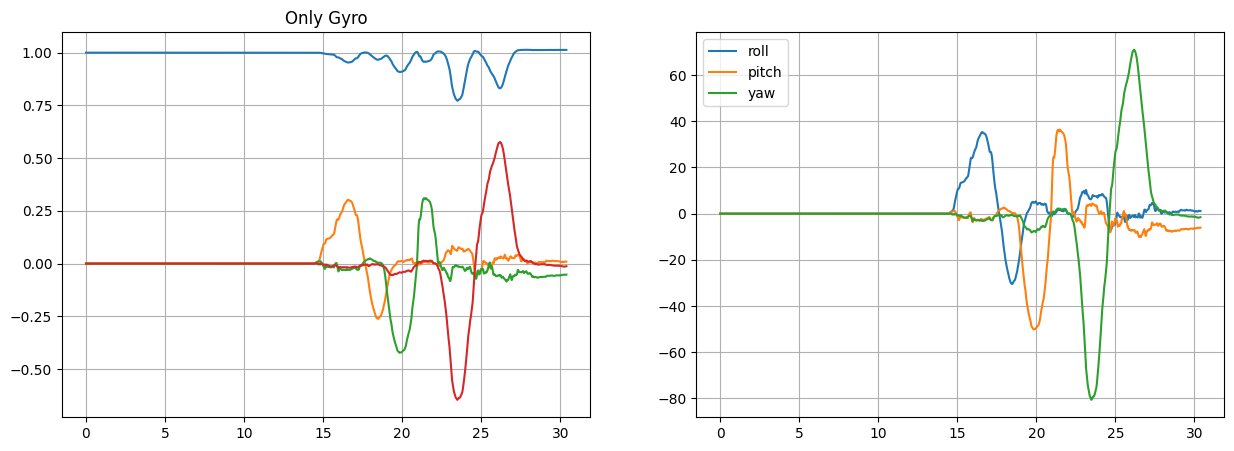

In [258]:
cf = CF(0.0) # only do the gyro update, not a CF anymore
qsave = []

last = ts[0]
for a,g,t in zip(accel, gyro, ts):
    dt = t - last
    last = t
    q = cf.update(a,g,dt)
    qsave.append(q) # alpha = 0, accel is ignored
    
plot(ts,qsave,"Only Gyro")

## Accel and Gyro

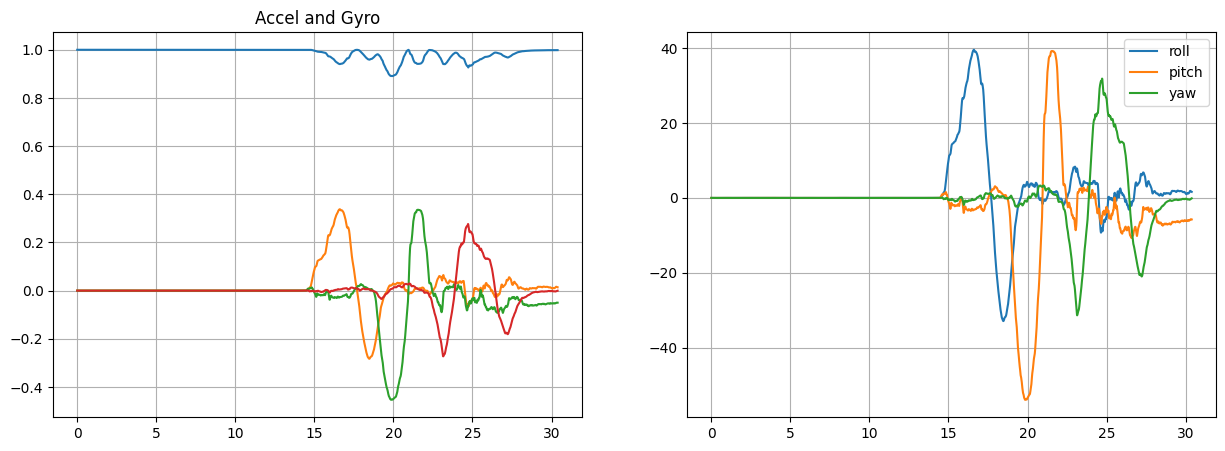

In [259]:
cf = CF(0.02)
qsave = []

last = ts[0]
for a,g,t in zip(accel, gyro, ts):
    dt = t - last
    last = t
    q = cf.update(a,g,dt)
    qsave.append(q)
    
plot(ts,qsave,"Accel and Gyro")

## Accel, Gyro, Mag

Now let fold in the magnetometer

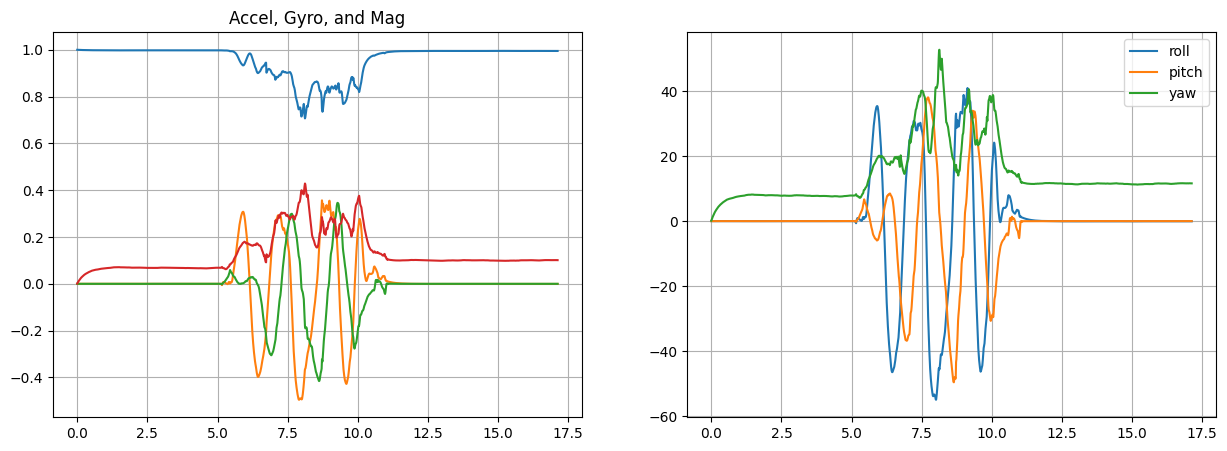

In [253]:
cf = CF(0.02)

qsave = []

last = ts[0]
for a,g,m,t in zip(accel, gyro, mag, ts):
    dt = t - last
    last = t
    q = cf.update(a,g,dt,m)
    qsave.append(q)
    
plot(ts,qsave,"Accel, Gyro, and Mag")

# Appendix A: Derivation

Using the normal Aerospace rotation (R321) we can see that if we multiply it by the gravity vector, only the last column is important since this is what the accelerometer sees.

$$
R321(x,y,z) =
\left[\begin{matrix}\cos{\left(y \right)} \cos{\left(z \right)} & \sin{\left(z \right)} \cos{\left(y \right)} & - \sin{\left(y \right)}\\\sin{\left(x \right)} \sin{\left(y \right)} \cos{\left(z \right)} - \sin{\left(z \right)} \cos{\left(x \right)} & \sin{\left(x \right)} \sin{\left(y \right)} \sin{\left(z \right)} + \cos{\left(x \right)} \cos{\left(z \right)} & \sin{\left(x \right)} \cos{\left(y \right)}\\\sin{\left(x \right)} \sin{\left(z \right)} + \sin{\left(y \right)} \cos{\left(x \right)} \cos{\left(z \right)} & - \sin{\left(x \right)} \cos{\left(z \right)} + \sin{\left(y \right)} \sin{\left(z \right)} \cos{\left(x \right)} & \cos{\left(x \right)} \cos{\left(y \right)}\end{matrix}\right] \\
\\
R321 * g = \left[\begin{matrix}- g \sin{\left(y \right)}\\g \sin{\left(x \right)} \cos{\left(y \right)}\\g \cos{\left(x \right)} \cos{\left(y \right)}\end{matrix}\right]
$$

> **Important:** Now look at the resultant term from multiplying with gravity ... there are NO yaw (z or $\psi$) terms ... you cannot get yaw from an accelerometer!!

Now, we will normalize accelerometer reading and we can use the reading (and some trig) to figure out the roll and pitch terms.

$$
\frac {a} {\| a \|} = 
\begin{bmatrix} a_x \\ a_y \\ a_z \end{bmatrix} = 
\begin{bmatrix} -g\sin(\theta) \\ g\sin(\phi) \cos (\theta) \\ g\cos (\theta) \cos (\phi) \end{bmatrix}
$$

### Roll

First let's look at roll.

$$
\tan (\phi) = \frac {a_y}{a_z} = \frac {g\sin(\phi) \cos (\theta) } {g\cos (\theta) \cos (\phi)} = \frac {\sin(\phi)} {\cos (\phi)} \\
\phi = \arctan (a_y, a_z)
$$

### Pitch

Now let's look at pitch.

$$
\begin{align}
\tan(\theta) &= \frac {-a_x}{m} \\
m &= a_y \cdot \sin (\phi) + a_z \cdot cos(\phi) \\
 &= g\sin(\phi) \cos (\theta) \sin(\phi) + g\cos (\theta) \cos (\phi) cos(\phi) \\
 &= g \left( \sin^2 (\phi) + \cos^2 (\phi) \right) \cos(\theta) \\
 &=g \cos(\theta) \\
 \\
\theta &= \arctan (- \sin(\theta), \cos(\theta) )
\end{align}
$$

Or, to avoid usings transidental $\sin$ or $\cos$ functions, square the terms.

$$
\begin{align}
m &= a_y^2 + a_z^2 \\
  &= g^2 \sin^2 (\phi) \cos^2 (\theta) + g^2 \cos^2 (\phi) cos^2 (\theta) \\
  &= g^2 \cos^2 (\theta) \left( \sin^2 (\phi) + \cos^2 (\phi) \right) \\
  &= g^2 \cos^2 (\theta) \\
\\
\tan (\theta) &= \frac {-a_x}{\sqrt {a_y^2 + a_z^2 }} \\
              &= \frac {-g\sin(\theta)} {g\cos(\theta)}
\end{align}
$$

In [164]:
import sympy as sp

In [165]:
try:
    from rotations.sym_rotations import sR321
except ImportError:
    def sR321(x,y,z):
        """Returns a rotation matrix based on: X(x)*Y(y)*Z(z)"""
        s3 = sp.sin(x); c3 = sp.cos(x)
        s2 = sp.sin(y); c2 = sp.cos(y)
        s1 = sp.sin(z); c1 = sp.cos(z)

        r = np.array(
            [
                [         c1*c2,          c2*s1,  -s2],
                [c1*s2*s3-c3*s1, c1*c3+s1*s2*s3, c2*s3],
                [s1*s3+c1*c3*s2, c3*s1*s2-c1*s3, c2*c3]
            ]
        )
        return sp.Matrix(r)

In [166]:
# r,p,y = sp.symbols('r p y')
x,y,z = sp.symbols('x y z')
g = sp.symbols('g')

rot = sR321(x,y,z)
# rot = R321(y,p,r)

rot[:,2]

⎡   -sin(y)   ⎤
⎢             ⎥
⎢sin(x)⋅cos(y)⎥
⎢             ⎥
⎣cos(x)⋅cos(y)⎦

In [167]:
rot

⎡           cos(y)⋅cos(z)                          sin(z)⋅cos(y)              
⎢                                                                             
⎢sin(x)⋅sin(y)⋅cos(z) - sin(z)⋅cos(x)  sin(x)⋅sin(y)⋅sin(z) + cos(x)⋅cos(z)   
⎢                                                                             
⎣sin(x)⋅sin(z) + sin(y)⋅cos(x)⋅cos(z)  -sin(x)⋅cos(z) + sin(y)⋅sin(z)⋅cos(x)  

   -sin(y)   ⎤
             ⎥
sin(x)⋅cos(y)⎥
             ⎥
cos(x)⋅cos(y)⎦

In [168]:
print(sp.latex(rot))
print("---------")
print(sp.latex(rot @ sp.Matrix([0,0,g])))

\left[\begin{matrix}\cos{\left(y \right)} \cos{\left(z \right)} & \sin{\left(z \right)} \cos{\left(y \right)} & - \sin{\left(y \right)}\\\sin{\left(x \right)} \sin{\left(y \right)} \cos{\left(z \right)} - \sin{\left(z \right)} \cos{\left(x \right)} & \sin{\left(x \right)} \sin{\left(y \right)} \sin{\left(z \right)} + \cos{\left(x \right)} \cos{\left(z \right)} & \sin{\left(x \right)} \cos{\left(y \right)}\\\sin{\left(x \right)} \sin{\left(z \right)} + \sin{\left(y \right)} \cos{\left(x \right)} \cos{\left(z \right)} & - \sin{\left(x \right)} \cos{\left(z \right)} + \sin{\left(y \right)} \sin{\left(z \right)} \cos{\left(x \right)} & \cos{\left(x \right)} \cos{\left(y \right)}\end{matrix}\right]
---------
\left[\begin{matrix}- g \sin{\left(y \right)}\\g \sin{\left(x \right)} \cos{\left(y \right)}\\g \cos{\left(x \right)} \cos{\left(y \right)}\end{matrix}\right]


In [229]:
def test():
    from math import asin, cos, sin, atan2, pi
    
    mx=10.40327262878418
    my=26.24196434020996
    mz=-41.379310607910156
    
    ax=-0.0103759765625
    ay=0.01123046875
    az=1.01904296875
    
    mn = np.linalg.norm(np.array([mx,my,mz]))
    an = np.linalg.norm(np.array([ax,ay,az]))
    
    ax /= an
    ay /= an
    az /= an
    
    mx /= mn
    my /= mn
    mz /= mn
    print("Mag:",mx,my,mz)

    pitch = asin(-ax)

    if abs(pitch) >= pi/2:
        roll = 0.0
    else:
        roll = asin(ay/cos(pitch))

    # mx, my, mz = mag
    x = mx*cos(pitch)+mz*sin(pitch)
    y = mx*sin(roll)*sin(pitch)+my*cos(roll)-mz*sin(roll)*cos(pitch)
    yaw = atan2(y, x)
    
    print(f"Euler: {np.array([roll, pitch, yaw])*180/pi}")
    print(f"Alt: {90 - atan2(my,mx)*180/pi}")
    print(f"Alt: {atan2(mx,my)*180/pi}")

test()

Mag: 0.207687136957712 0.5238849962352212 -0.8260814511063245
Euler: [ 0.63140852  0.5833346  69.50063486]
Alt: 21.625182097520366
Alt: 21.62518209752036


In [221]:
np.arctan2(.25,.65)

In [225]:
np.pi/2 - np.arctan2(.25,.65)

In [224]:
np.arctan2(.65,.25)